# Imports

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from scipy.stats import skew
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
import os

# Mount Google Drive

In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/DEP2'

Mounted at /content/drive


Helper functions

In [ ]:
def show_value_counts(data):
  data['score'].round(0).value_counts().sort_values()[data['score'].round(0).sort_values().unique()].plot(kind='bar', figsize=(30, 10))

  print(skew(data['score']), data['score'].round(0).value_counts())

# Load data and create train_test_split if needed

In [ ]:
reload_data = True

if reload_data or not os.path.exists(f"{data_path}/train.csv"):
    data = pd.read_csv(f'{data_path}/mldata.csv')

    # Drop unwanted columns
    data = data.drop('ondernemingsnummer', axis=1)
    data = data.drop('sector', axis=1)
    data = data.drop('beursgenoteerd', axis=1)

    # Round score values
    data['score'] = data['score'].round(0)

    # Make categorical data categorical
    #data['beursgenoteerd'] = data['beursgenoteerd'].astype('category')
    data['verstedelijkingsgraad'] = data['verstedelijkingsgraad'].astype('category')
    #data['sector'] = data['sector'].astype('category')
    data['hoofdsector'] = data['hoofdsector'].astype('category')

    #one-hot encoding
    data = pd.get_dummies(data)

    data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
    #save train and test set to drive
    data_train.to_csv(f'{data_path}/train.csv', index=False)
    data_test.to_csv(f'{data_path}/test.csv', index=False)

    data = data_train

else:
  data = pd.read_csv(f'{data_path}/train.csv')

# Visualize output data

1.0046868383135326 6.0     806
5.0     721
9.0     660
10.0    656
8.0     641
11.0    586
7.0     576
12.0    553
13.0    484
14.0    432
15.0    363
16.0    347
17.0    312
18.0    285
20.0    242
19.0    241
22.0    225
21.0    221
23.0    179
24.0    157
25.0    155
0.0     120
26.0    117
27.0    104
28.0     96
29.0     68
4.0      67
31.0     59
30.0     58
32.0     39
33.0     33
3.0      28
1.0      26
34.0     25
2.0      23
35.0     18
36.0     14
37.0     12
38.0     12
40.0      9
41.0      7
39.0      7
45.0      5
42.0      3
43.0      2
44.0      2
54.0      2
46.0      2
47.0      2
Name: score, dtype: int64


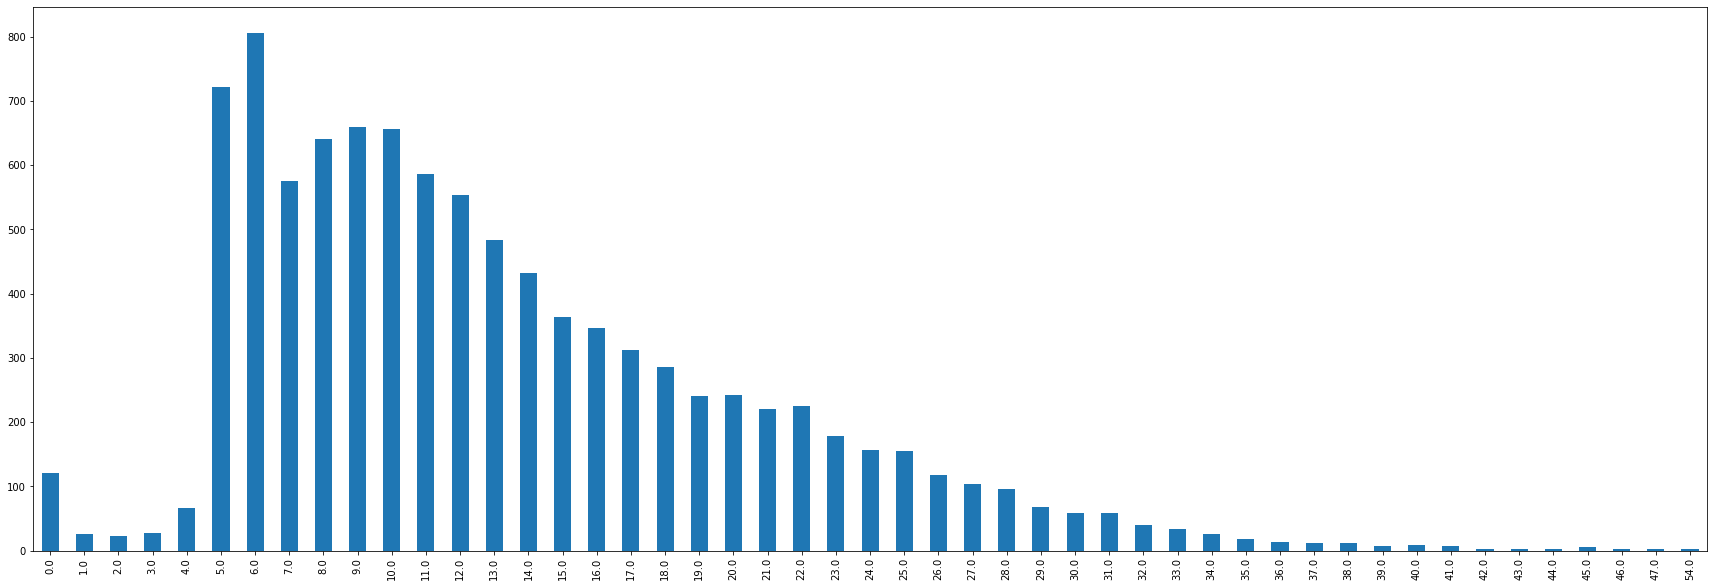

In [ ]:
show_value_counts(data)

Output data is skewed towards values between 5 and 20

Drop records with under-represented classes

In [ ]:
grouped = data.groupby(data['score'].round(0))
filtered_df = grouped.filter(lambda x: len(x) > 200)
data = filtered_df.reset_index()

0.503540938367367 6.0     806
5.0     721
9.0     660
10.0    656
8.0     641
11.0    586
7.0     576
12.0    553
13.0    484
14.0    432
15.0    363
16.0    347
17.0    312
18.0    285
20.0    242
19.0    241
22.0    225
21.0    221
Name: score, dtype: int64


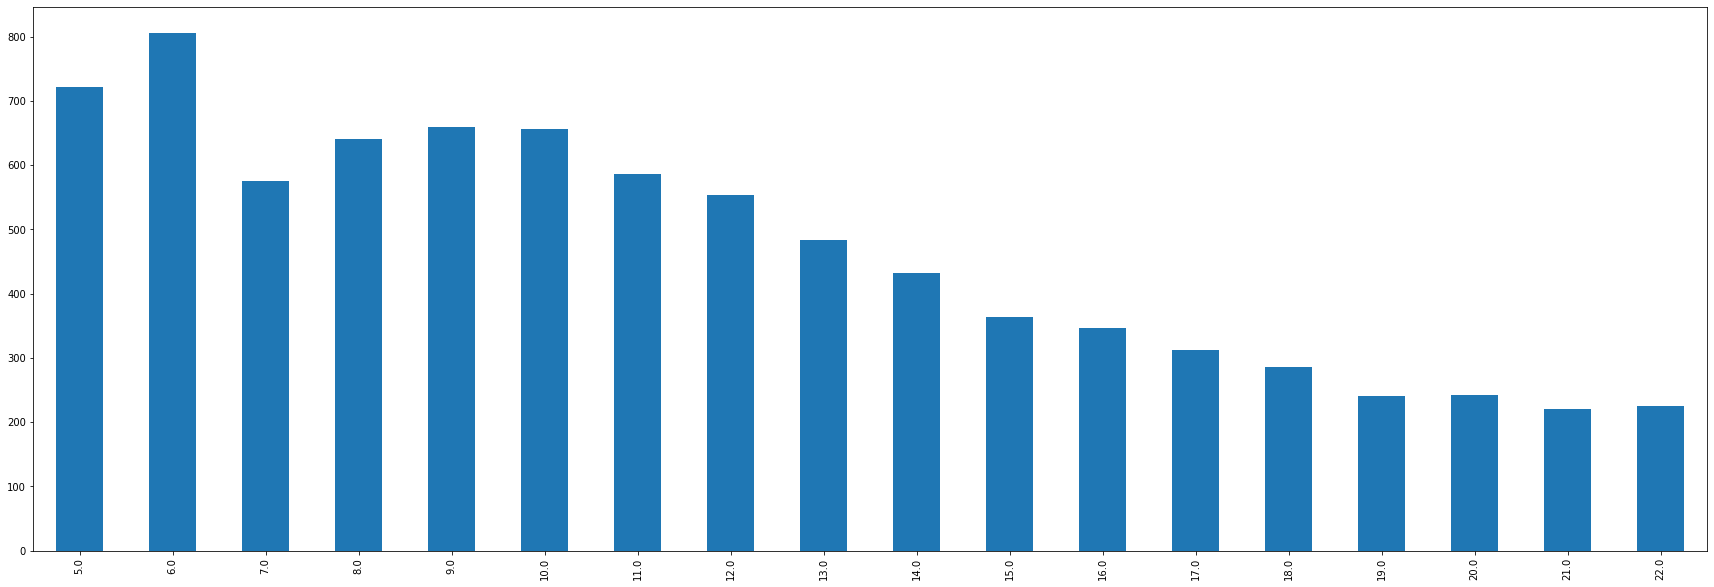

In [ ]:
show_value_counts(data)

Reduce over-represented classes

In [ ]:
data['rounded'] = data['score'].round(0)
avg_samples = data['rounded'].value_counts().mean()
min_samples = data['rounded'].value_counts().min()
grouped = data.groupby('rounded')

def reduce_skewness_avg(group):
    return group.sample(int(avg_samples))

def reduce_skewness_min(group):
  return group.sample(int(min_samples))

balanced_df_avg = pd.concat([grouped.apply(lambda x: reduce_skewness_avg(x) if len(x) > avg_samples else x)])
balanced_df_min = pd.concat([grouped.apply(lambda x: reduce_skewness_min(x))])
data = balanced_df_min.drop('rounded', axis=1).reset_index().drop('rounded', axis=1).drop(['level_1', 'index'], axis=1)
data

,aantalwerknemers,omzet,omzetperwerknemer,balanstotaal,score,verstedelijkingsgraad_0.0,verstedelijkingsgraad_1.0,verstedelijkingsgraad_2.0,hoofdsector_A,hoofdsector_B,...,hoofdsector_K,hoofdsector_L,hoofdsector_M,hoofdsector_N,hoofdsector_O,hoofdsector_P,hoofdsector_Q,hoofdsector_R,hoofdsector_S,hoofdsector_T
0,19,0,0.000000,2835493,5.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,13,0,0.000000,2344390,5.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,19,4199,221.000000,1164660,5.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26,0,0.000000,2470236,5.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,0,0.000000,5913353,5.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3973,34,2410,70.882353,1092219,22.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3974,33,6080,184.242424,1724582,22.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3975,33,25288,766.303030,17737190,22.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3976,36,50446,1401.277778,32017870,22.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0.0 5.0     221
6.0     221
21.0    221
20.0    221
19.0    221
18.0    221
17.0    221
16.0    221
15.0    221
14.0    221
13.0    221
12.0    221
11.0    221
10.0    221
9.0     221
8.0     221
7.0     221
22.0    221
Name: score, dtype: int64


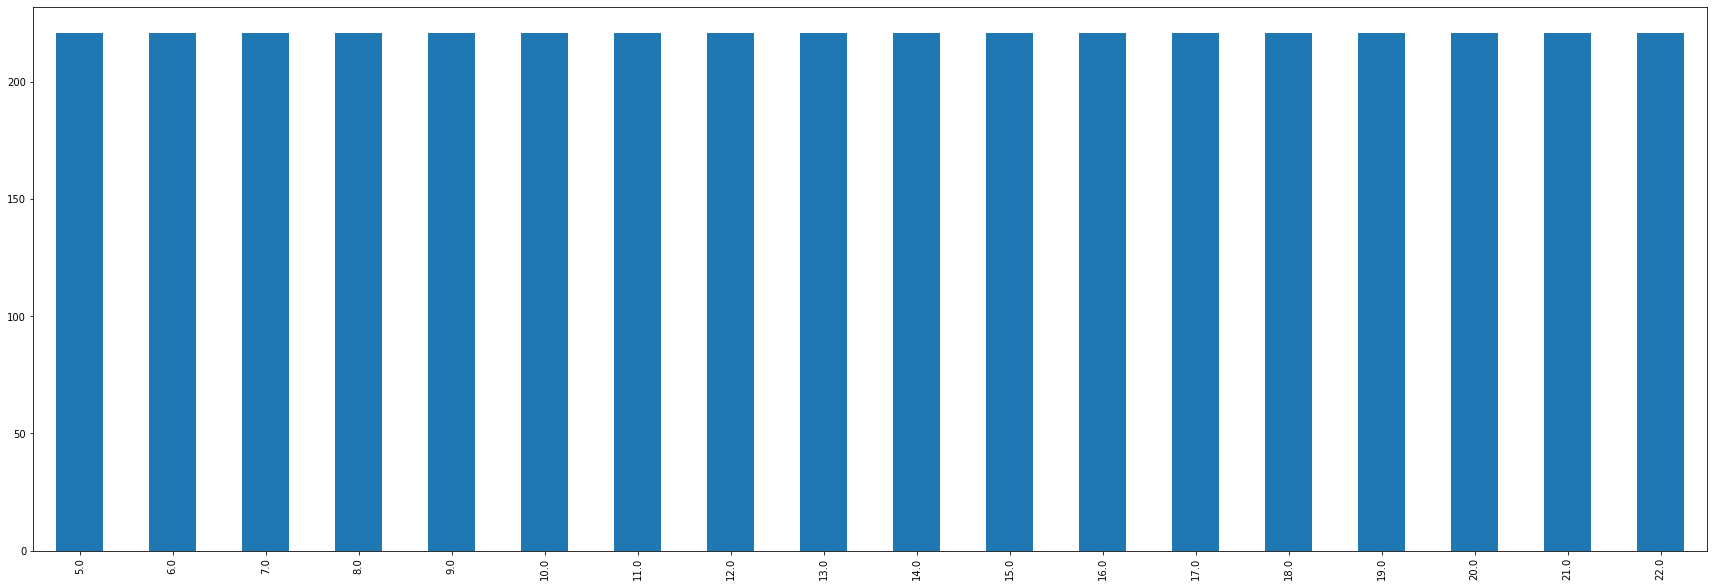

In [ ]:
show_value_counts(data)

In [ ]:
data.to_csv(f'{data_path}/cleaned.csv', index=False)
